In [1]:
import pandas as pd
import numpy as np
import transformers
from datasets import load_dataset
from sklearn import metrics
import re
import matplotlib.pyplot as plt
from pathlib import Path

Dataset_ag = load_dataset("ag_news")
Testds=pd.DataFrame({'text':Dataset_ag['test']['text'],'label':Dataset_ag['test']['label']}).reset_index(drop=True)
Length_filtered_test=Testds[Testds['text'].str.len()<=1000].reset_index(drop=True)
Trainds=pd.DataFrame({'text':Dataset_ag['train']['text'],'label':Dataset_ag['train']['label']}).reset_index(drop=True)
Length_filtered_train=Trainds[Trainds['text'].str.len()<=1000].reset_index(drop=True)

Found cached dataset ag_news (C:/Users/sepehrc/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

# BERT base

In [2]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
def EmbeddingModel(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    res = np.array(embedding[0][0][1:-1])
    return res

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [3]:
file="Embeddings\outfile_ag_news_train.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

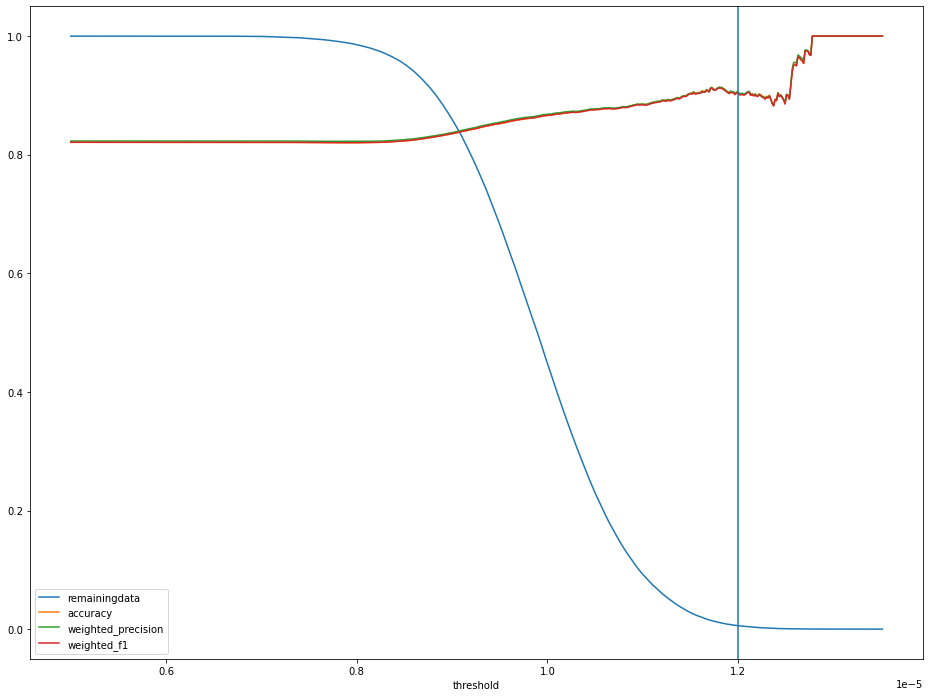

In [4]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.000005, 0.00002, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(.000012)

In [5]:
results[results['weighted_f1']==results[results['threshold']<=.000012]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
453,0.912439,0.913626,0.913859,0.913626,1343.0,1343.0,1343.0,0.908098,0.869049,0.886345,1343.0,0.000012,0.011192


In [6]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [7]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.000005, 0.00002, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.815017,0.815,0.817083,0.815,7600.0,7600.0,7600.0,0.817083,0.815,0.815017,7600.0,0.000005
1,0.815017,0.815,0.817083,0.815,7600.0,7600.0,7600.0,0.817083,0.815,0.815017,7600.0,0.000005
2,0.815017,0.815,0.817083,0.815,7600.0,7600.0,7600.0,0.817083,0.815,0.815017,7600.0,0.000005
3,0.815017,0.815,0.817083,0.815,7600.0,7600.0,7600.0,0.817083,0.815,0.815017,7600.0,0.000005
4,0.815017,0.815,0.817083,0.815,7600.0,7600.0,7600.0,0.817083,0.815,0.815017,7600.0,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.333333,0.500,0.250000,0.500,2.0,2.0,2.0,0.250000,0.500,0.333333,2.0,0.000013
516,0.333333,0.500,0.250000,0.500,2.0,2.0,2.0,0.250000,0.500,0.333333,2.0,0.000013
517,0.333333,0.500,0.250000,0.500,2.0,2.0,2.0,0.250000,0.500,0.333333,2.0,0.000013
518,0.000000,0.000,0.000000,0.000,1.0,1.0,1.0,0.000000,0.000,0.000000,1.0,0.000013


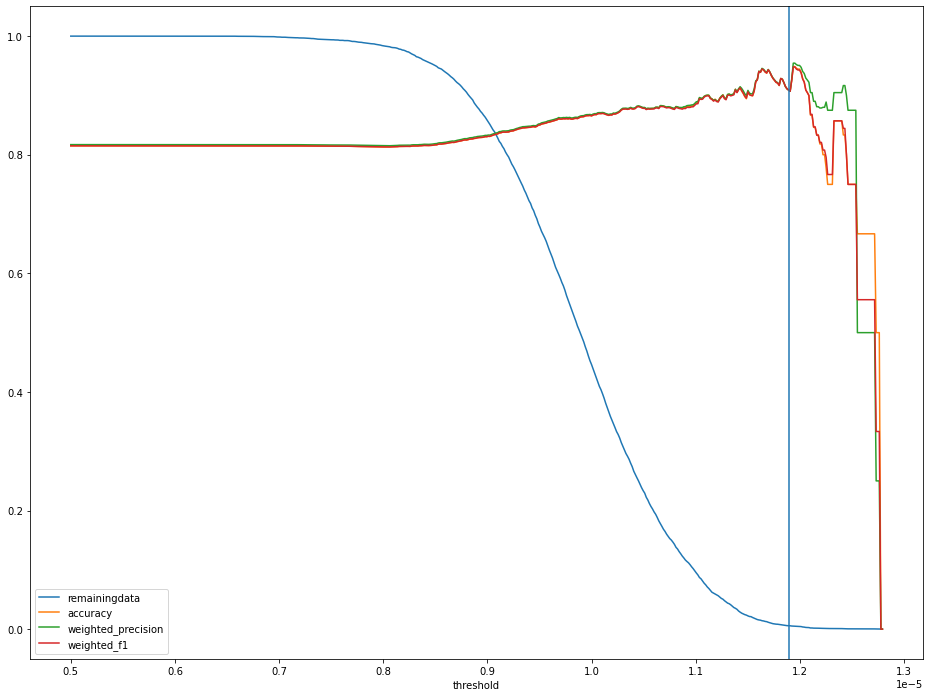

In [8]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(.0000119)

In [9]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=.0000119]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
442,0.944676,0.944444,0.945661,0.944444,108.0,108.0,108.0,0.952108,0.952497,0.952083,108.0,0.000012,0.014211


# BERT Large

In [10]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
nlp = TFBertModel.from_pretrained("bert-large-uncased")
def EmbeddingModel(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    res = np.array(embedding[0][0][1:-1])
    return res

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
file="Embeddings\outfile_ag_news_train_bertlarge.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

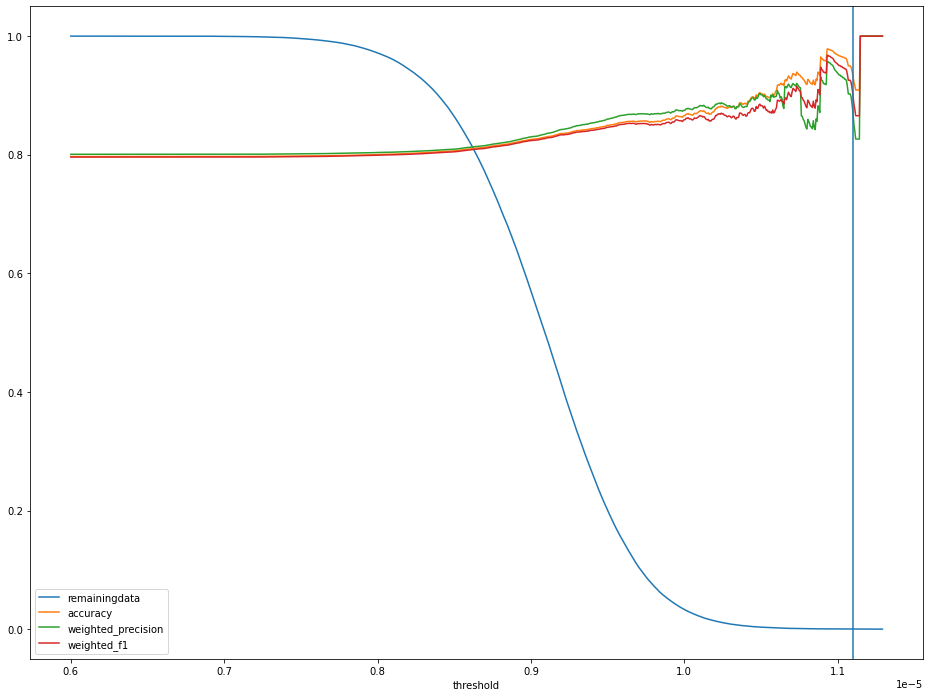

In [12]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.000006, 0.000012, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000111)

In [13]:
results[results['weighted_f1']==results[results['threshold']<=0.0000111]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
821,0.967511,0.978261,0.956994,0.978261,46.0,46.0,46.0,0.48913,0.5,0.494505,46.0,0.000011,0.000383
822,0.967511,0.978261,0.956994,0.978261,46.0,46.0,46.0,0.48913,0.5,0.494505,46.0,0.000011,0.000383


In [14]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_bertlarge.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [15]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.000006, 0.000012, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.785196,0.786316,0.789488,0.786316,7600.0,7600.0,7600.0,0.789488,0.786316,0.785196,7600.0,0.000006
1,0.785196,0.786316,0.789488,0.786316,7600.0,7600.0,7600.0,0.789488,0.786316,0.785196,7600.0,0.000006
2,0.785196,0.786316,0.789488,0.786316,7600.0,7600.0,7600.0,0.789488,0.786316,0.785196,7600.0,0.000006
3,0.785196,0.786316,0.789488,0.786316,7600.0,7600.0,7600.0,0.789488,0.786316,0.785196,7600.0,0.000006
4,0.785196,0.786316,0.789488,0.786316,7600.0,7600.0,7600.0,0.789488,0.786316,0.785196,7600.0,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
832,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011
833,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011
834,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011
835,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011


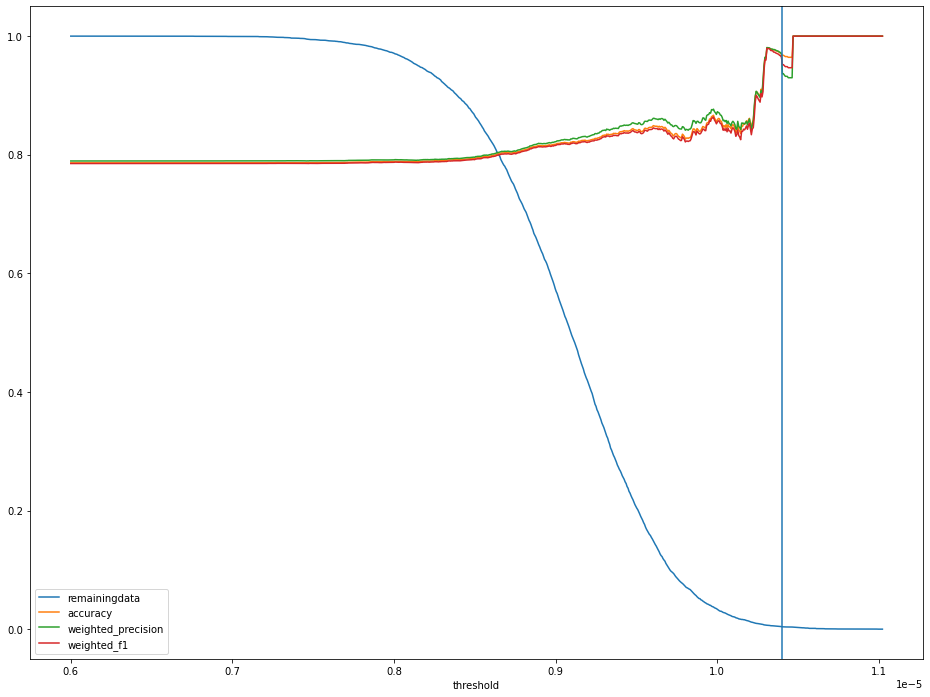

In [16]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000104)

In [17]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=0.0000104]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
717,0.979408,0.980392,0.980809,0.980392,51.0,51.0,51.0,0.989362,0.9,0.939068,51.0,0.00001,0.006711


# DistilBERT base

In [18]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
nlp = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
def EmbeddingModel(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    res = np.array(embedding[0][0][1:-1])
    return res

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [19]:
file="Embeddings\outfile_ag_news_train_distilbert.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

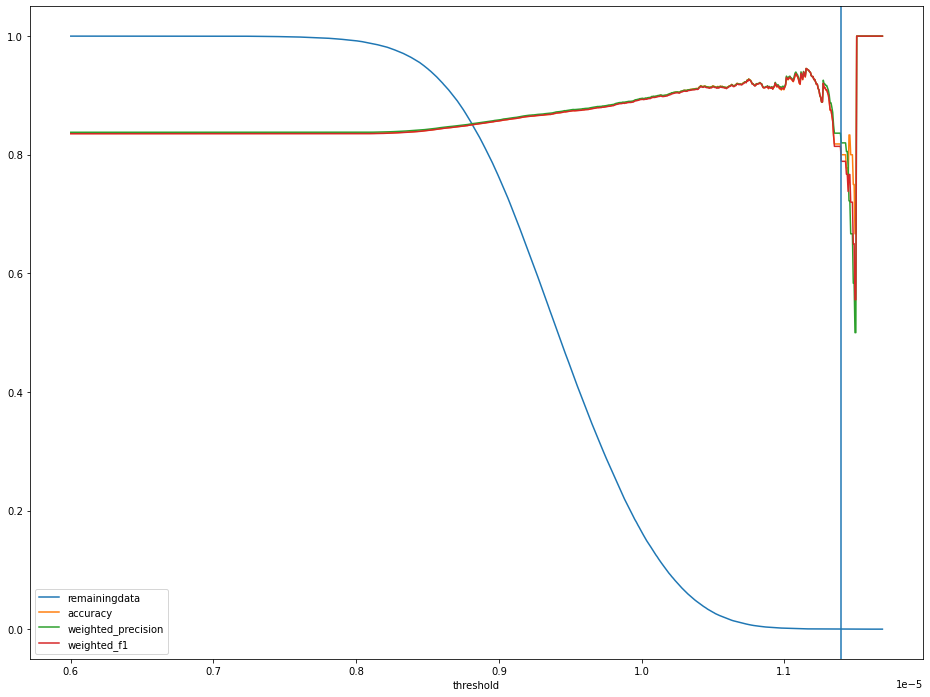

In [20]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.000006, 0.000012, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000114)

In [21]:
results[results['weighted_f1']==results[results['threshold']<=0.0000114]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
858,0.945455,0.945455,0.945455,0.945455,55.0,55.0,55.0,0.942613,0.942613,0.942613,55.0,0.000011,0.000458


In [22]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_distilbert.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [23]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.000006, 0.000012, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.827245,0.828026,0.830028,0.828026,7600.0,7600.0,7600.0,0.830028,0.828026,0.827245,7600.0,0.000006
1,0.827245,0.828026,0.830028,0.828026,7600.0,7600.0,7600.0,0.830028,0.828026,0.827245,7600.0,0.000006
2,0.827245,0.828026,0.830028,0.828026,7600.0,7600.0,7600.0,0.830028,0.828026,0.827245,7600.0,0.000006
3,0.827245,0.828026,0.830028,0.828026,7600.0,7600.0,7600.0,0.830028,0.828026,0.827245,7600.0,0.000006
4,0.827245,0.828026,0.830028,0.828026,7600.0,7600.0,7600.0,0.830028,0.828026,0.827245,7600.0,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
889,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011
890,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011
891,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011
892,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000011


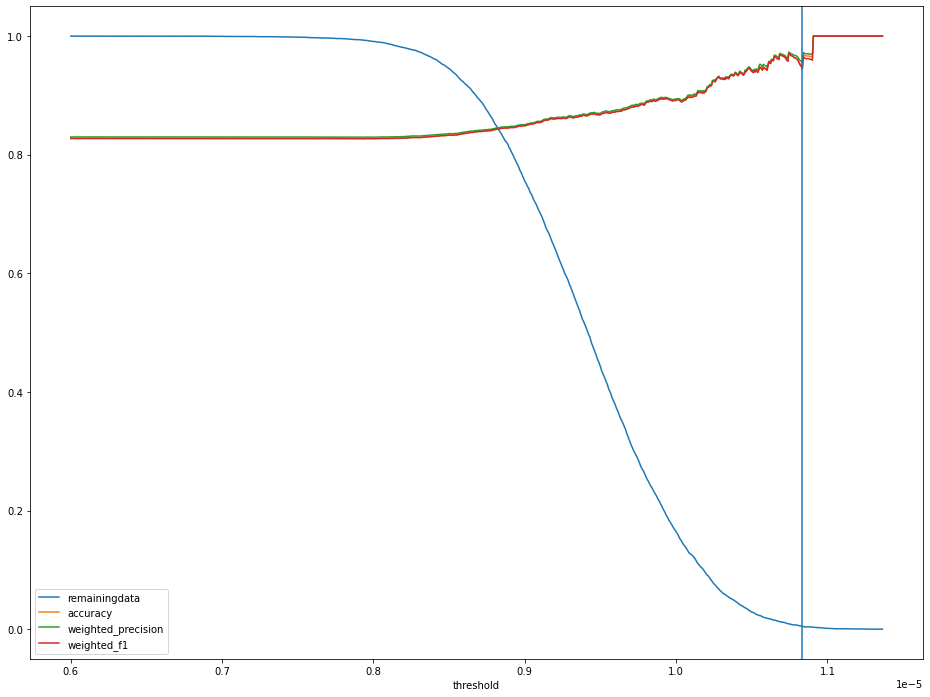

In [24]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.00001083)

In [25]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=0.00001083]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
790,0.971047,0.971429,0.973399,0.971429,70.0,70.0,70.0,0.982759,0.943243,0.959869,70.0,0.000011,0.009211


# ALBERT

In [26]:
from transformers import AlbertTokenizer, TFAlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
nlp = TFAlbertModel.from_pretrained("albert-base-v2")
def EmbeddingModel(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    res = np.array(embedding[0][0][1:-1])
    return res

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [27]:
file="Embeddings\outfile_ag_news_train_albert.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

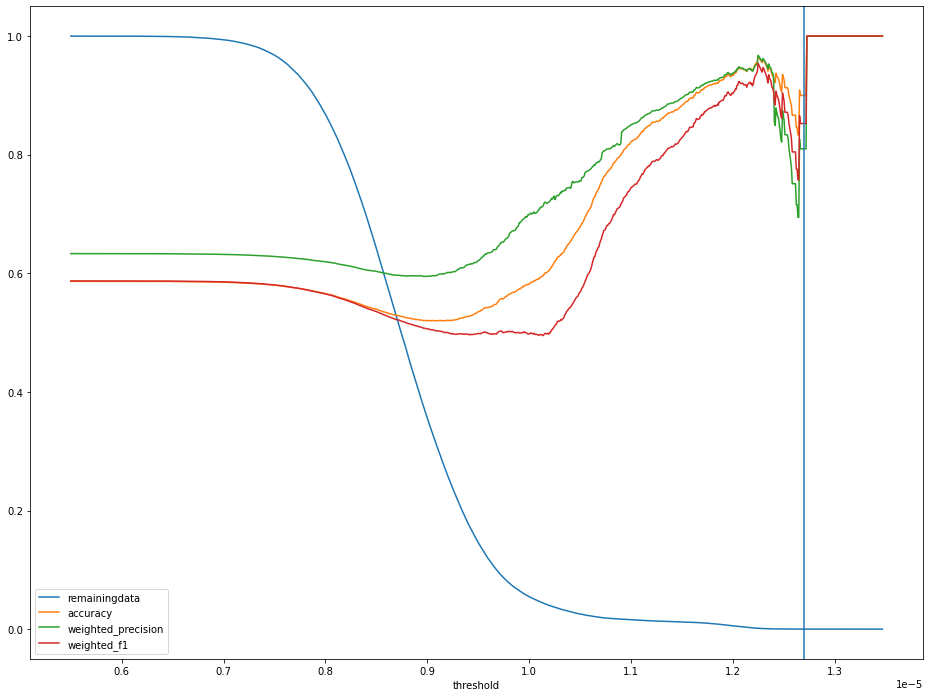

In [28]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000055, 0.0000134685, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000127)

In [29]:
results[results['weighted_f1']==results[results['threshold']<=0.0000127]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
846,0.953942,0.966292,0.967435,0.966292,178.0,178.0,178.0,0.983051,0.571429,0.616379,178.0,0.000012,0.001483


In [30]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_albert.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [31]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000055, 0.0000134685, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.577031,0.575526,0.619687,0.575526,7600.0,7600.0,7600.0,0.619687,0.575526,0.577031,7600.0,0.000005
1,0.577031,0.575526,0.619687,0.575526,7600.0,7600.0,7600.0,0.619687,0.575526,0.577031,7600.0,0.000006
2,0.577031,0.575526,0.619687,0.575526,7600.0,7600.0,7600.0,0.619687,0.575526,0.577031,7600.0,0.000006
3,0.577031,0.575526,0.619687,0.575526,7600.0,7600.0,7600.0,0.619687,0.575526,0.577031,7600.0,0.000006
4,0.577031,0.575526,0.619687,0.575526,7600.0,7600.0,7600.0,0.619687,0.575526,0.577031,7600.0,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
875,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000012
876,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000012
877,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000012
878,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000013


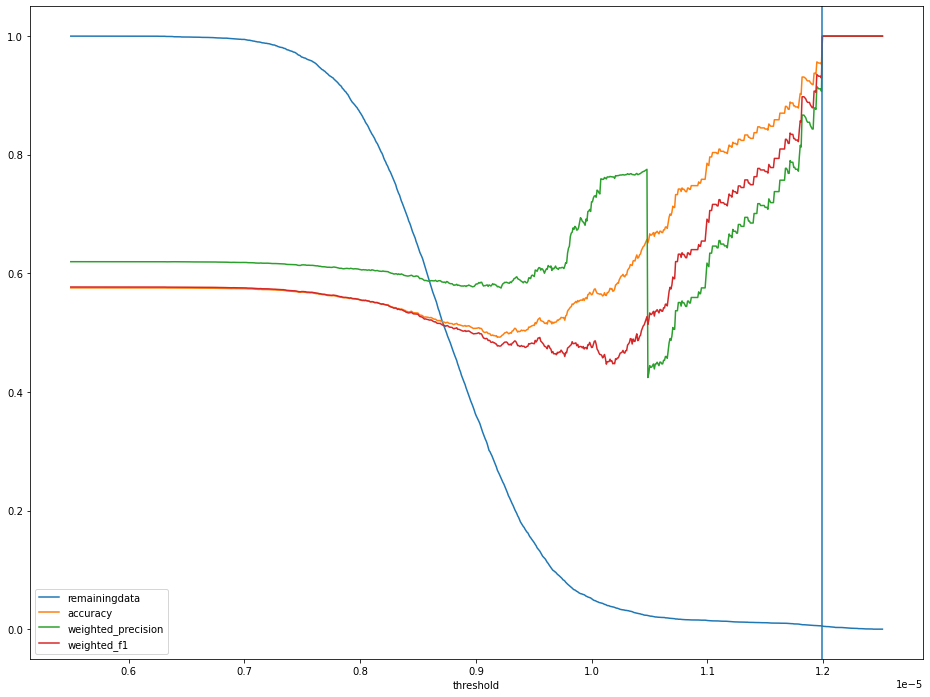

In [32]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.00001199)

In [33]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=0.00001199]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
808,0.935266,0.956522,0.914934,0.956522,46.0,46.0,46.0,0.478261,0.5,0.488889,46.0,0.000012,0.006053


# BigBird Base

In [34]:
from transformers import AutoTokenizer, AutoModelForPreTraining, BigBirdModel
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-roberta-base")
nlp = BigBirdModel.from_pretrained("google/bigbird-roberta-base")

def EmbeddingModel(txt, tokenizer, nlp):
    encoded_input = tokenizer(txt, return_tensors='pt')
    embedding = nlp(**encoded_input)
    res = np.array(embedding[0][0][1:-1].detach().numpy())
    return res

In [35]:
file="Embeddings\outfile_ag_news_train_bigbirdbase.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

Attention type 'block_sparse' is not possible if sequence_length: 13 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


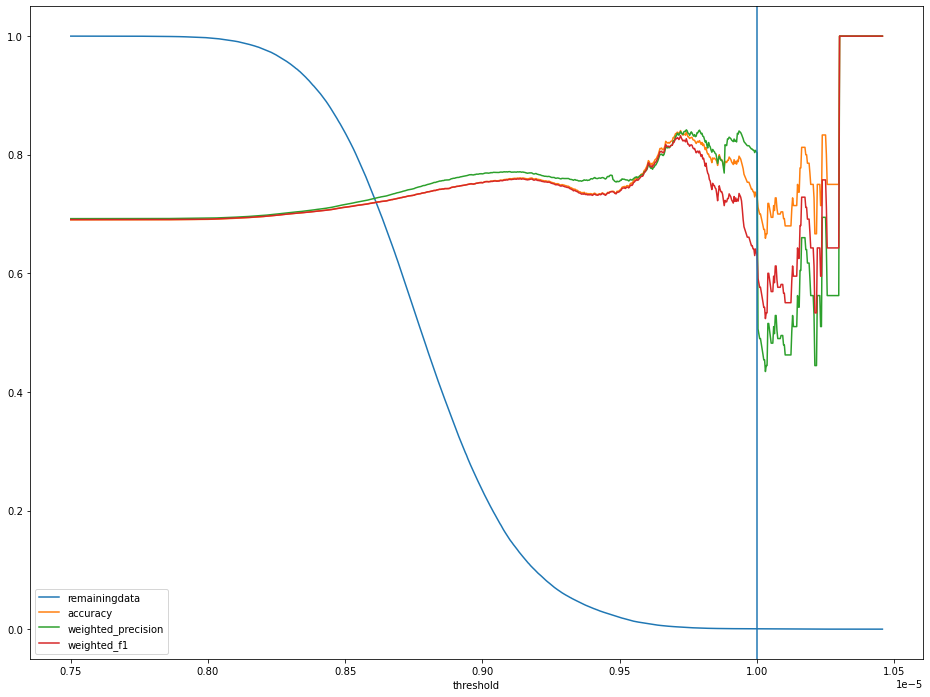

In [36]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000075, 0.0000105, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.00001)

In [37]:
results[results['weighted_f1']==results[results['threshold']<=0.00001]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
740,0.832093,0.840749,0.839097,0.840749,427.0,427.0,427.0,0.571757,0.551937,0.556148,427.0,0.00001,0.003559


In [38]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_bigbirdbase.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [39]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000075, 0.0000105, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.684244,0.683816,0.686369,0.683816,7600.0,7600.0,7600.0,0.686369,0.683816,0.684244,7600.0,0.000008
1,0.684244,0.683816,0.686369,0.683816,7600.0,7600.0,7600.0,0.686369,0.683816,0.684244,7600.0,0.000008
2,0.684244,0.683816,0.686369,0.683816,7600.0,7600.0,7600.0,0.686369,0.683816,0.684244,7600.0,0.000008
3,0.684244,0.683816,0.686369,0.683816,7600.0,7600.0,7600.0,0.686369,0.683816,0.684244,7600.0,0.000008
4,0.684244,0.683816,0.686369,0.683816,7600.0,7600.0,7600.0,0.686369,0.683816,0.684244,7600.0,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...
847,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000010
848,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000010
849,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000010
850,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,0.000010


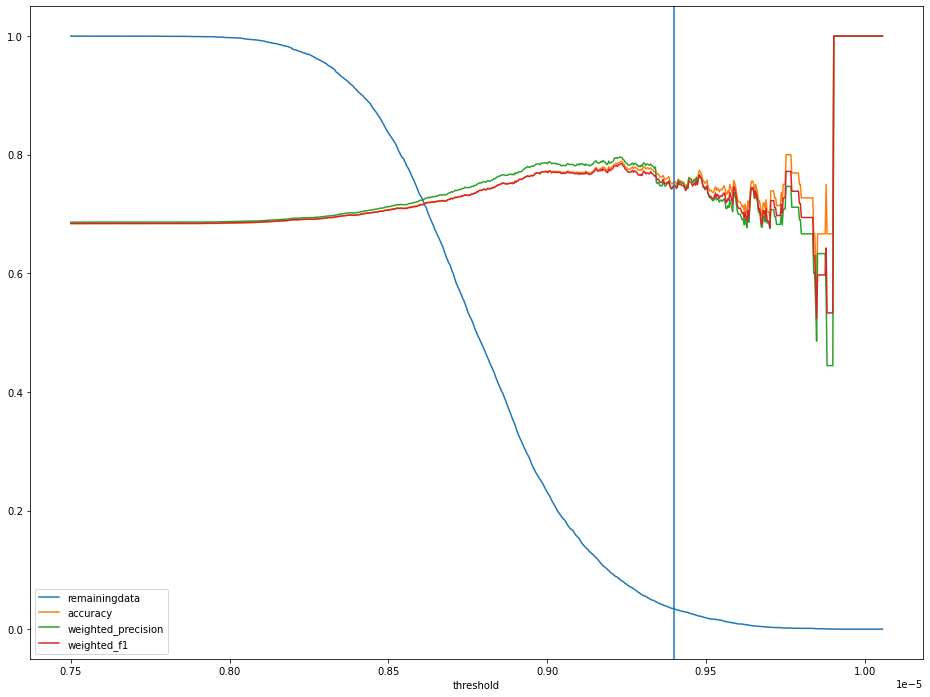

In [40]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000094)

In [41]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=0.0000094]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
577,0.78515,0.789137,0.795733,0.789137,626.0,626.0,626.0,0.828029,0.721881,0.722608,626.0,0.000009,0.082368


# BERT base multi

In [42]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
nlp = TFBertModel.from_pretrained("bert-base-multilingual-cased")
def EmbeddingModel(txt, tokenizer, nlp):
    encoded_input = tokenizer(txt, return_tensors='tf')
    embedding = nlp(encoded_input)
    res = np.array(embedding[0][0][1:-1])
    return res

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
file="Embeddings\outfile_ag_news_train_bertmulti.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

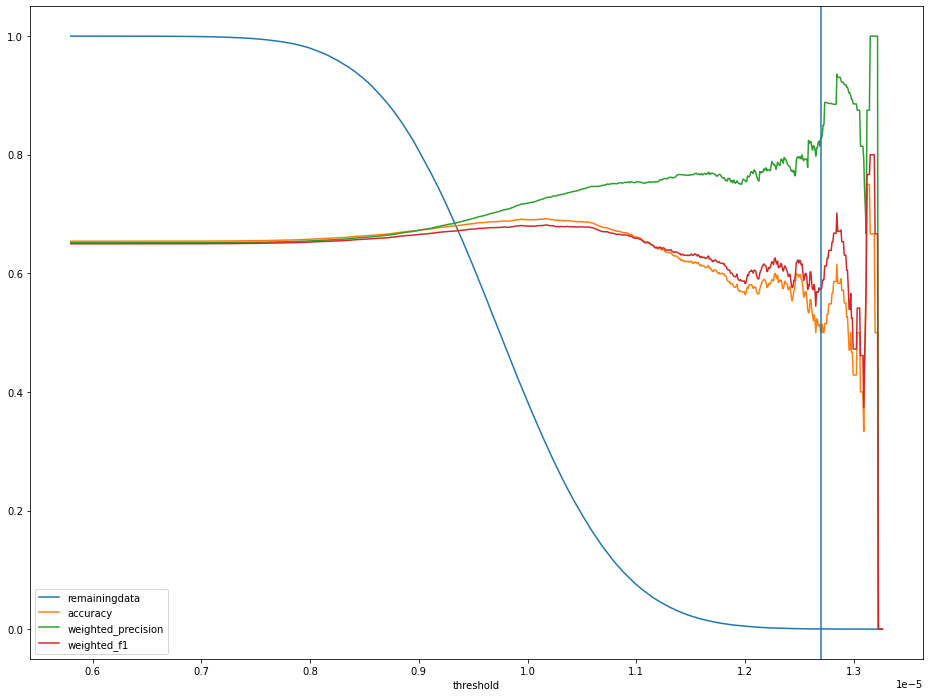

In [44]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000058, 0.0000132625, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000127)

In [45]:
results[results['weighted_f1']==results[results['threshold']<=0.0000127]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
586,0.681535,0.692042,0.727926,0.692042,37070.0,37070.0,37070.0,0.697134,0.758199,0.698747,37070.0,0.00001,0.308932


In [46]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_bigbirdbase.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [47]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000058, 0.0000132625, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.171522,0.233158,0.181196,0.233158,7600.0,7600.0,7600.0,0.181196,0.233158,0.171522,7600.0,0.000006
1,0.171522,0.233158,0.181196,0.233158,7600.0,7600.0,7600.0,0.181196,0.233158,0.171522,7600.0,0.000006
2,0.171522,0.233158,0.181196,0.233158,7600.0,7600.0,7600.0,0.181196,0.233158,0.171522,7600.0,0.000006
3,0.171522,0.233158,0.181196,0.233158,7600.0,7600.0,7600.0,0.181196,0.233158,0.171522,7600.0,0.000006
4,0.171522,0.233158,0.181196,0.233158,7600.0,7600.0,7600.0,0.181196,0.233158,0.171522,7600.0,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.166112,0.238709,0.181461,0.238709,6598.0,6598.0,6598.0,0.183897,0.248649,0.170606,6598.0,0.000013
996,0.166019,0.238550,0.181400,0.238550,6594.0,6594.0,6594.0,0.183849,0.248607,0.170561,6594.0,0.000013
997,0.166050,0.238586,0.181492,0.238586,6593.0,6593.0,6593.0,0.183939,0.248616,0.170580,6593.0,0.000013
998,0.166119,0.238659,0.181563,0.238659,6591.0,6591.0,6591.0,0.183998,0.248635,0.170626,6591.0,0.000013


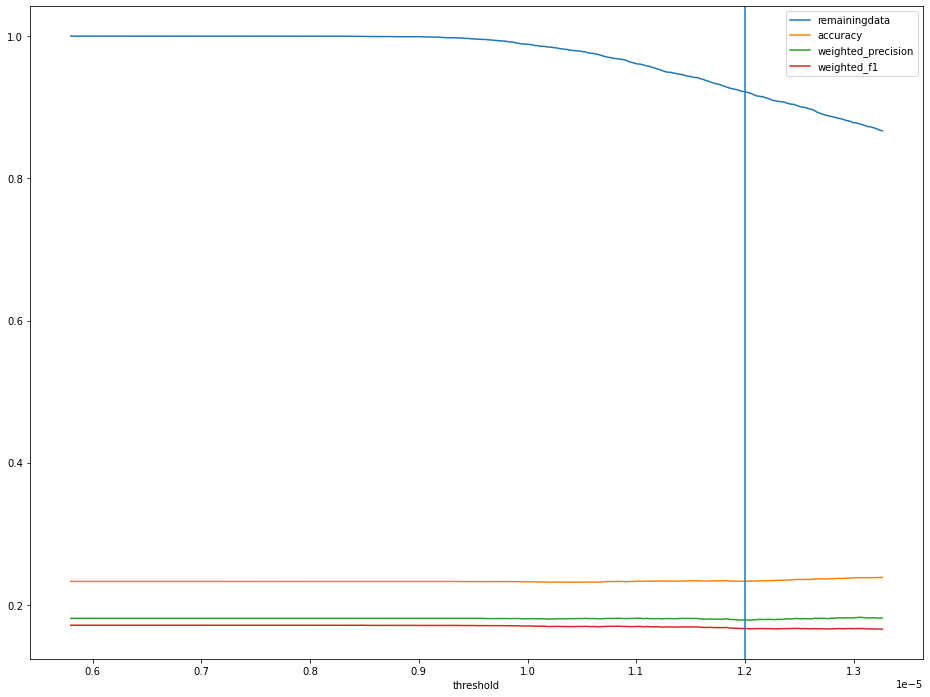

In [48]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.000012)

In [49]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=0.000012]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
324,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
325,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
326,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
327,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
328,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
329,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
330,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
331,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
332,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868
333,0.171549,0.233189,0.181275,0.233189,7599.0,7599.0,7599.0,0.181268,0.233167,0.171539,7599.0,0.000008,0.999868


# BigBird large

In [50]:
from transformers import AutoTokenizer, AutoModelForPreTraining, BigBirdModel
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-roberta-large")
nlp = BigBirdModel.from_pretrained("google/bigbird-roberta-large")

def EmbeddingModel(txt, tokenizer, nlp):
    encoded_input = tokenizer(txt, return_tensors='pt')
    embedding = nlp(**encoded_input)
    res = np.array(embedding[0][0][1:-1].detach().numpy())
    return res

In [51]:
file="Embeddings\outfile_ag_news_train_bigbirdlarge.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

Attention type 'block_sparse' is not possible if sequence_length: 13 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


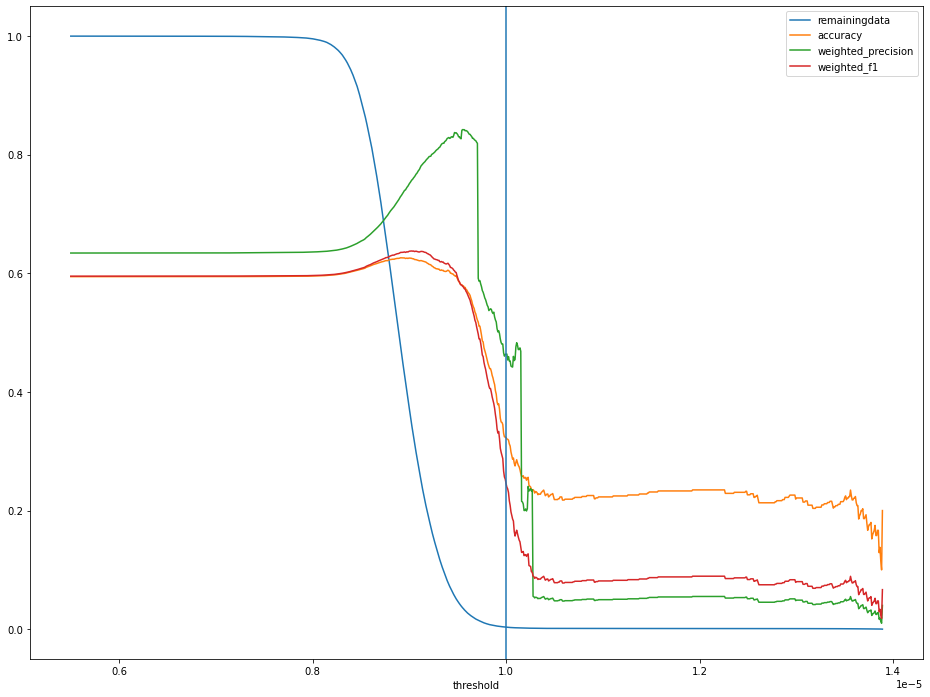

In [52]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000055, 0.00001395, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.00001)

In [53]:
results[results['weighted_f1']==results[results['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
416,0.637817,0.625498,0.755741,0.625498,42128.0,42128.0,42128.0,0.718376,0.632191,0.606344,42128.0,0.000009,0.351084


In [54]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_bigbirdlarge.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [55]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000055, 0.00001395, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.586508,0.586053,0.626606,0.586053,7600.0,7600.0,7600.0,0.626606,0.586053,0.586508,7600.0,0.000005
1,0.586508,0.586053,0.626606,0.586053,7600.0,7600.0,7600.0,0.626606,0.586053,0.586508,7600.0,0.000006
2,0.586508,0.586053,0.626606,0.586053,7600.0,7600.0,7600.0,0.626606,0.586053,0.586508,7600.0,0.000006
3,0.586508,0.586053,0.626606,0.586053,7600.0,7600.0,7600.0,0.626606,0.586053,0.586508,7600.0,0.000006
4,0.586508,0.586053,0.626606,0.586053,7600.0,7600.0,7600.0,0.626606,0.586053,0.586508,7600.0,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...
977,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000014
978,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000014
979,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000014
980,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000014


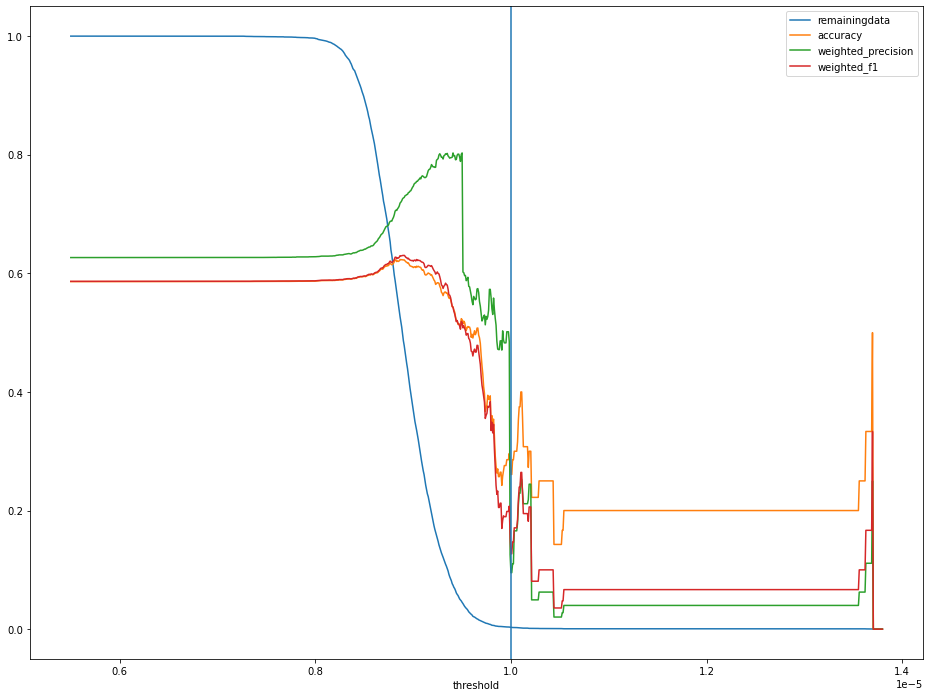

In [56]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.00001)

In [57]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
403,0.630387,0.62273,0.727958,0.62273,3634.0,3634.0,3634.0,0.702287,0.6309,0.611655,3634.0,0.000009,0.478158


# RoBERTa

In [58]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
nlp = TFRobertaModel.from_pretrained('roberta-base')
def EmbeddingModel(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    res = np.array(embedding[0][0][1:-1])
    return res

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [59]:
file="Embeddings\outfile_ag_news_train_roberta.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

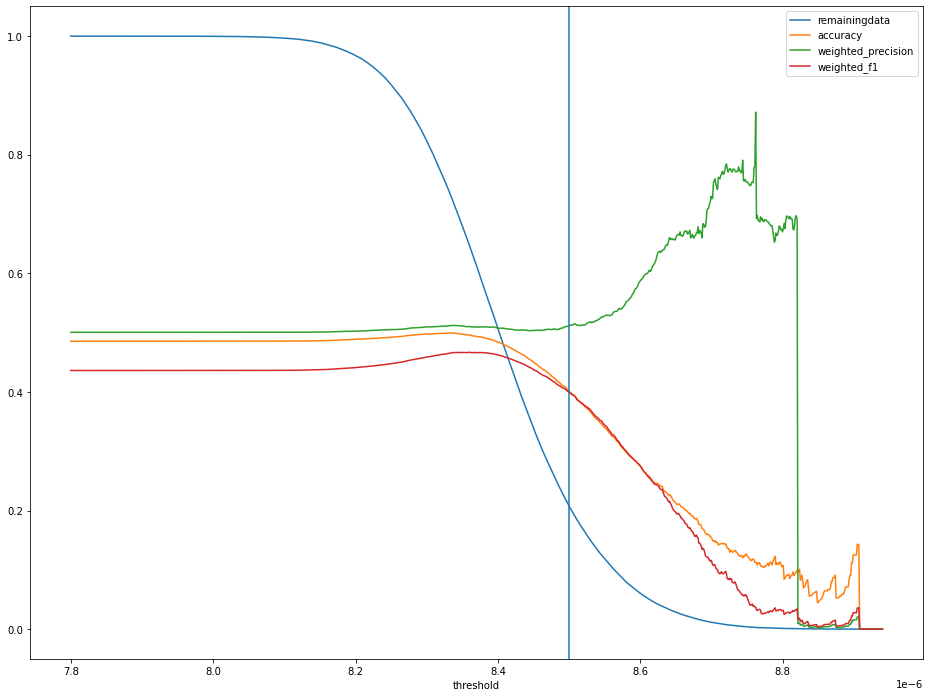

In [60]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000078, 0.0000089399, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000085)

In [61]:
results[results['weighted_f1']==results[results['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
490,0.466762,0.496132,0.510248,0.496132,77953.0,77953.0,77953.0,0.501525,0.474421,0.44359,77953.0,0.000008,0.649641


In [62]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_roberta.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [63]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000078, 0.0000089399, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.430499,0.48,0.495896,0.48,7600.0,7600.0,7600.0,0.495896,0.48,0.430499,7600.0,0.000008
1,0.430499,0.48,0.495896,0.48,7600.0,7600.0,7600.0,0.495896,0.48,0.430499,7600.0,0.000008
2,0.430499,0.48,0.495896,0.48,7600.0,7600.0,7600.0,0.495896,0.48,0.430499,7600.0,0.000008
3,0.430499,0.48,0.495896,0.48,7600.0,7600.0,7600.0,0.495896,0.48,0.430499,7600.0,0.000008
4,0.430499,0.48,0.495896,0.48,7600.0,7600.0,7600.0,0.495896,0.48,0.430499,7600.0,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...
952,0.000000,0.00,0.000000,0.00,1.0,1.0,1.0,0.000000,0.00,0.000000,1.0,0.000009
953,0.000000,0.00,0.000000,0.00,1.0,1.0,1.0,0.000000,0.00,0.000000,1.0,0.000009
954,0.000000,0.00,0.000000,0.00,1.0,1.0,1.0,0.000000,0.00,0.000000,1.0,0.000009
955,0.000000,0.00,0.000000,0.00,1.0,1.0,1.0,0.000000,0.00,0.000000,1.0,0.000009


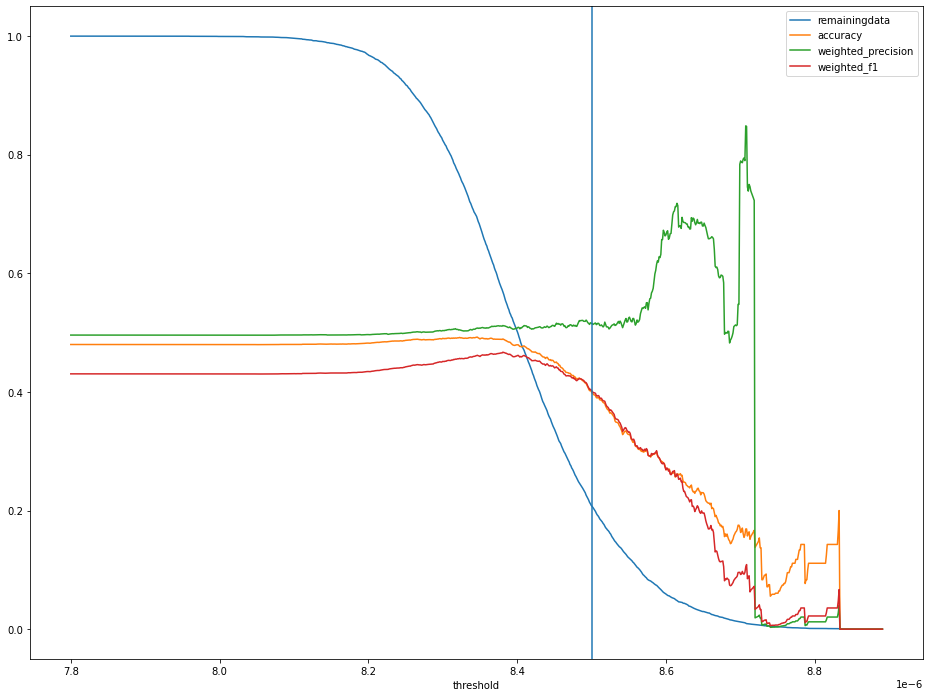

In [64]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.0000085)

In [65]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
509,0.467086,0.489352,0.511993,0.489352,4320.0,4320.0,4320.0,0.498337,0.464337,0.438578,4320.0,0.000008,0.568421


# GPT2

In [66]:
from transformers import GPT2Tokenizer, TFGPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
nlp = TFGPT2Model.from_pretrained('gpt2')
def EmbeddingModel(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    res = np.array(embedding[0][0])
    return res

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [67]:
file="Embeddings\outfile_ag_news_train_gpt2.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

<AxesSubplot:xlabel='threshold'>

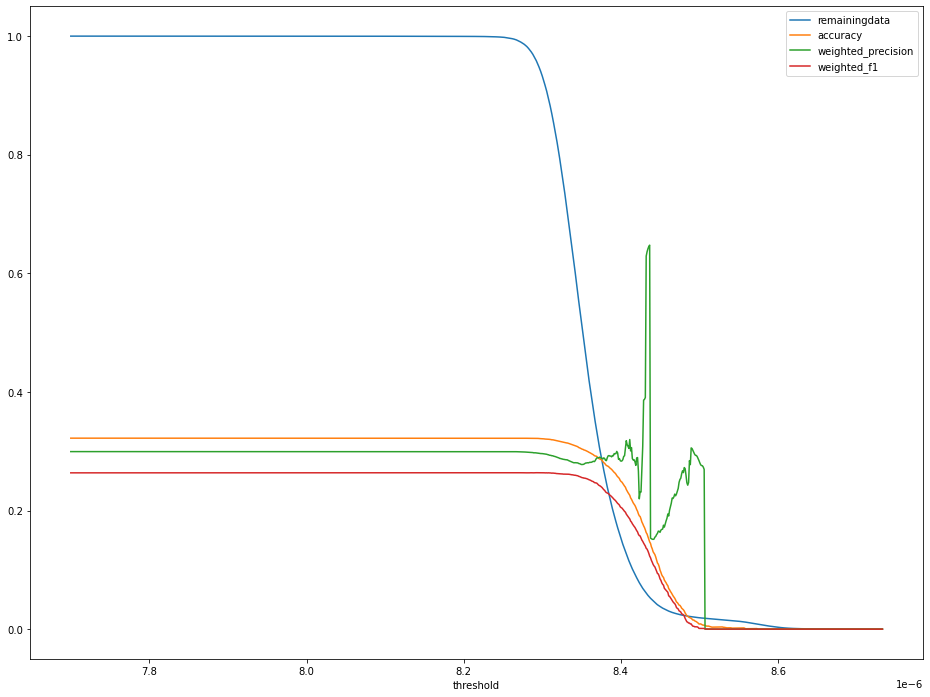

In [68]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000077, 0.0000088, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))


In [69]:
results[results['weighted_f1']==results[results['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
537,0.263846,0.321854,0.297364,0.321854,115363.0,115363.0,115363.0,0.297584,0.322898,0.264447,115363.0,0.000008,0.961406


In [70]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_gpt2.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [71]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria','pakistan','israel','arabs','afghanistan']
Keyword_vector["world2"] =  ['clashes ','troops','residents','government','disaster']
Keyword_vector["sports"] =  ['times','player','team','time']
Keyword_vector["sports2"] =  ['championship','stadium','scores']
Keyword_vector["sports3"] =  ['NBA','basketball']
Keyword_vector["business"] =  ['business','wall street','buy','sell','investment','oil']
Keyword_vector["business2"] =  ['stocks','exports','dollars','asset','budget']
Keyword_vector["business3"] =  ['merger','acquisition','bank','economic']
Keyword_vector["business4"] =  ['financial','initial public offering','market','shares']
Keyword_vector["business5"] =  ['mutual fund','stock','equity','growth','pay']
Keyword_vector["business7"] =  ['company','tax','price']
Keyword_vector["sci"] =  ['electronics','science','internet','software','technology']
Keyword_vector["sci2"] =  ['environment','global warming','climate change']
Keyword_vector["sci3"] =  ['player','copyright','microsoft','google','apple','technology']
Keyword_vector["sci4"] =  ['nasa','space','Spacecraft','earth','moon','Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000078, 0.0000089399, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.256686,0.316842,0.285335,0.316842,7600.0,7600.0,7600.0,0.285335,0.316842,0.256686,7600.0,0.000008
1,0.256686,0.316842,0.285335,0.316842,7600.0,7600.0,7600.0,0.285335,0.316842,0.256686,7600.0,0.000008
2,0.256686,0.316842,0.285335,0.316842,7600.0,7600.0,7600.0,0.285335,0.316842,0.256686,7600.0,0.000008
3,0.256686,0.316842,0.285335,0.316842,7600.0,7600.0,7600.0,0.285335,0.316842,0.256686,7600.0,0.000008
4,0.256686,0.316842,0.285335,0.316842,7600.0,7600.0,7600.0,0.285335,0.316842,0.256686,7600.0,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000009
800,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000009
801,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000009
802,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.000009


<AxesSubplot:xlabel='threshold'>

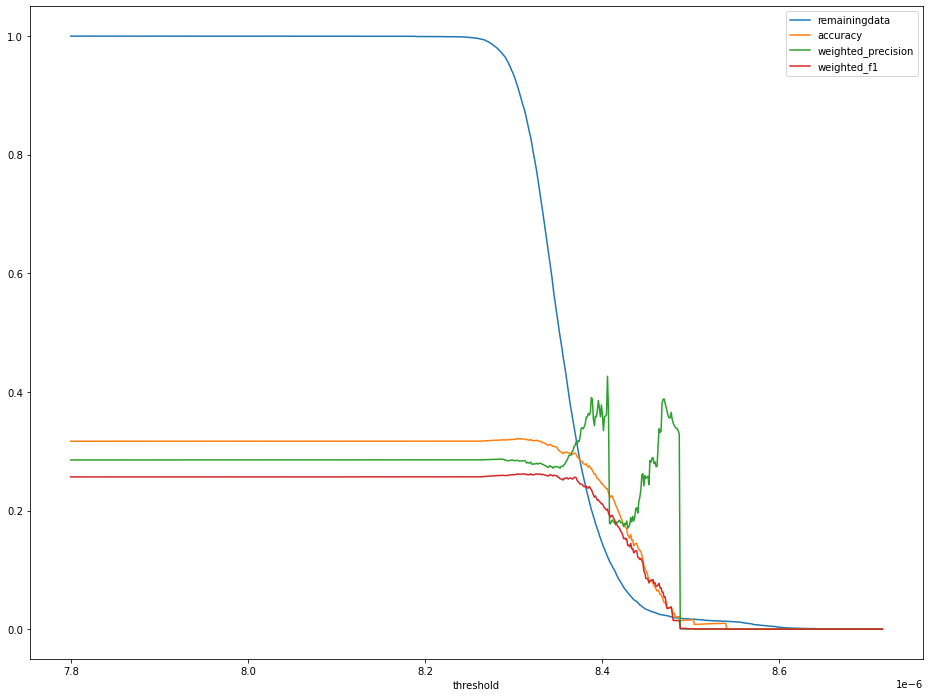

In [72]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))

In [73]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
461,0.262042,0.318608,0.27995,0.318608,5863.0,5863.0,5863.0,0.27996,0.321026,0.263572,5863.0,0.000008,0.771447


# DistilBERT multi

In [74]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
nlp = TFBertModel.from_pretrained("distilbert-base-multilingual-cased")
def EmbeddingModel(txt, tokenizer, nlp):
    encoded_input = tokenizer(txt, return_tensors='tf')
    embedding = nlp(encoded_input)
    res = np.array(embedding[0][0][1:-1])
    return res

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.2.sa_layer_norm.bias', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.1.output_layer_norm.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.3.ffn.lin2.bias', 'distilbert.e

In [75]:
file="Embeddings\outfile_ag_news_train_distilbertmulti.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_train['text']]
    X = np.array(Meanval)

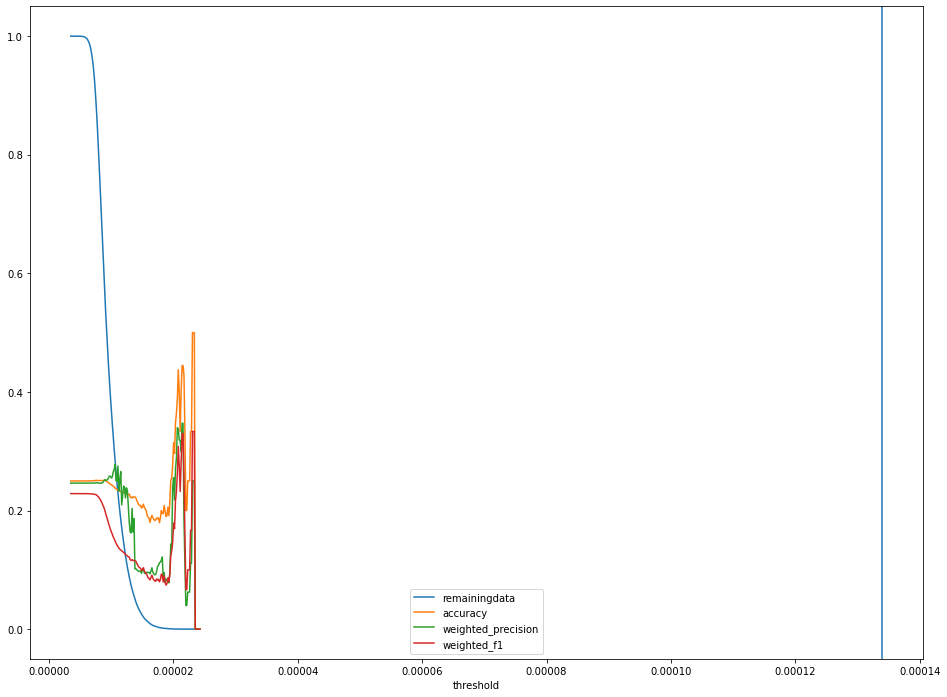

In [76]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)

labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])

    
    
empty=[]
results=pd.DataFrame()
vals=np.linspace(0.0000035, 0.000155, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_train['tag']=tags
    Length_filtered_train=Length_filtered_train.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_train2=Length_filtered_train[Length_filtered_train['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_train2['label'])>0 and len(Length_filtered_train2['tag'])>0):
        report=metrics.classification_report(Length_filtered_train2['label'], Length_filtered_train2['tag'], digits=6, zero_division=0).split('\n')
        results.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        results.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        results.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        results.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        results.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        results.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        results.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        results.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        results.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        results.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        results.loc[trshld,'length']=len(Length_filtered_train2)
        results.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_train2)])

results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.000134)

In [77]:
results[results['weighted_f1']==results[results['threshold']<=0.000134]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
129,0.333333,0.5,0.25,0.5,2.0,2.0,2.0,0.25,0.5,0.333333,2.0,0.000023,0.000017
130,0.333333,0.5,0.25,0.5,2.0,2.0,2.0,0.25,0.5,0.333333,2.0,0.000023,0.000017
131,0.333333,0.5,0.25,0.5,2.0,2.0,2.0,0.25,0.5,0.333333,2.0,0.000023,0.000017


In [78]:
referirv=[]
for i in range(len(alltopics)):
    referirv.append(similarities[i].mean())
file="Embeddings\outfile_ag_news_test_distilbertmulti.npy"
Embeddingfile = Path(file)
if Embeddingfile.is_file():
    X=np.load(file)
else:
    Meanval = [EmbeddingModel(txt, tokenizer, nlp).mean(0) 
                 for txt in Length_filtered_test['text']]
    X = np.array(Meanval)

In [79]:
Keyword_vector = {}
Keyword_vector["world"] =  ['syria''pakistan''israel''arabs''afghanistan']
Keyword_vector["world2"] =  ['clashes ''troops''residents''government''disaster']
Keyword_vector["sports"] =  ['times''player''team''time']
Keyword_vector["sports2"] =  ['championship''stadium''scores']
Keyword_vector["sports3"] =  ['NBA''basketball']
Keyword_vector["business"] =  ['business''wall street''buy''sell''investment''oil']
Keyword_vector["business2"] =  ['stocks''exports''dollars''asset''budget']
Keyword_vector["business3"] =  ['merger''acquisition''bank''economic']
Keyword_vector["business4"] =  ['financial''initial public offering''market''shares']
Keyword_vector["business5"] =  ['mutual fund''stock''equity''growth''pay']
Keyword_vector["business7"] =  ['company''tax''price']
Keyword_vector["sci"] =  ['electronics''science''internet''software''technology']
Keyword_vector["sci2"] =  ['environment''global warming''climate change']
Keyword_vector["sci3"] =  ['player''copyright''microsoft''google''apple''technology']
Keyword_vector["sci4"] =  ['nasa''space''Spacecraft''earth''moon''Telescope']


dic_y = {k:EmbeddingModel(v, tokenizer, nlp).mean(0) for k,v in Keyword_vector.items()}

alltopics=[]
for i in dic_y:
    alltopics.append(dic_y[i].reshape(-1, 1))

similarities=[]
for i in range(len(alltopics)):
    zz=metrics.pairwise.cosine_similarity(X, alltopics[i].T)
    similarities.append(zz)
    
similarities=np.array(similarities)


meanss=[]
labels = list(dic_y.keys())
for i in range(len(similarities)):

    similarities[i] = similarities[i] / sum(similarities[i])
    meanss.append(similarities[i].mean())
zarayeb = [ii / jj for ii, jj in zip(referirv, meanss)]
for i in range(len(similarities)):

    similarities[i] = (similarities[i])*zarayeb[i]
    
    
empty=[]
resultstestds=pd.DataFrame()
vals=np.linspace(0.0000035, 0.000155, num=1000)
for trshld in range(len(vals)):
    
    tags=[]
    for j in range(len(similarities[0])):
        if np.amax([similarities[:,j,0]]) <= vals[trshld]:
            label=999999
            tags.append(label)
        else:
            label=np.argmax([similarities[:,j,0]])
            tags.append(label)

    Length_filtered_test['tag']=tags
    Length_filtered_test=Length_filtered_test.replace({'tag' : {0:0,1: 0,  2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 3, 12: 3, 13: 3, 14: 3}})
    Length_filtered_test2=Length_filtered_test[Length_filtered_test['tag']!=999999].reset_index(drop=True)
    if (len(Length_filtered_test2['label'])>0 and len(Length_filtered_test2['tag'])>0):
        report=metrics.classification_report(Length_filtered_test2['label'], Length_filtered_test2['tag'], digits=6, zero_division=0).split('\n')
        resultstestds.loc[trshld,'weighted_f1']=float(re.sub(' +', ' ',report[-2]).split(' ')[4])
        resultstestds.loc[trshld,'weighted_recall']=float(re.sub(' +', ' ',report[-2]).split(' ')[3])
        resultstestds.loc[trshld,'weighted_precision']=float(re.sub(' +', ' ',report[-2]).split(' ')[2])
        resultstestds.loc[trshld,'accuracy']=float(re.sub(' +', ' ',report[-4]).split(' ')[2])
        resultstestds.loc[trshld,'supportaccur']=int(float(re.sub(' +', ' ',report[-4]).split(' ')[3]))
        resultstestds.loc[trshld,'supportmacro']=int(float(re.sub(' +', ' ',report[-3]).split(' ')[6]))
        resultstestds.loc[trshld,'supportweighted']=int(float(re.sub(' +', ' ',report[-2]).split(' ')[5]))
        resultstestds.loc[trshld,'macro_precision']=float(re.sub(' +', ' ',report[-3]).split(' ')[3])
        resultstestds.loc[trshld,'macro_recall']=float(re.sub(' +', ' ',report[-3]).split(' ')[4])
        resultstestds.loc[trshld,'macro_f1']=float(re.sub(' +', ' ',report[-3]).split(' ')[5])
        resultstestds.loc[trshld,'length']=len(Length_filtered_test2)
        resultstestds.loc[trshld,'threshold']=vals[trshld]
    else:
        empty.append([vals[trshld],len(Length_filtered_test2)])

resultstestds    

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold
0,0.206815,0.253553,0.264689,0.253553,7600.0,7600.0,7600.0,0.264689,0.253553,0.206815,7600.0,0.000003
1,0.206815,0.253553,0.264689,0.253553,7600.0,7600.0,7600.0,0.264689,0.253553,0.206815,7600.0,0.000004
2,0.206815,0.253553,0.264689,0.253553,7600.0,7600.0,7600.0,0.264689,0.253553,0.206815,7600.0,0.000004
3,0.206815,0.253553,0.264689,0.253553,7600.0,7600.0,7600.0,0.264689,0.253553,0.206815,7600.0,0.000004
4,0.206815,0.253553,0.264689,0.253553,7600.0,7600.0,7600.0,0.264689,0.253553,0.206815,7600.0,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.074878,0.213115,0.045418,0.213115,61.0,61.0,61.0,0.053279,0.250000,0.087838,61.0,0.000154
996,0.074878,0.213115,0.045418,0.213115,61.0,61.0,61.0,0.053279,0.250000,0.087838,61.0,0.000155
997,0.074878,0.213115,0.045418,0.213115,61.0,61.0,61.0,0.053279,0.250000,0.087838,61.0,0.000155
998,0.074878,0.213115,0.045418,0.213115,61.0,61.0,61.0,0.053279,0.250000,0.087838,61.0,0.000155


<AxesSubplot:xlabel='threshold'>

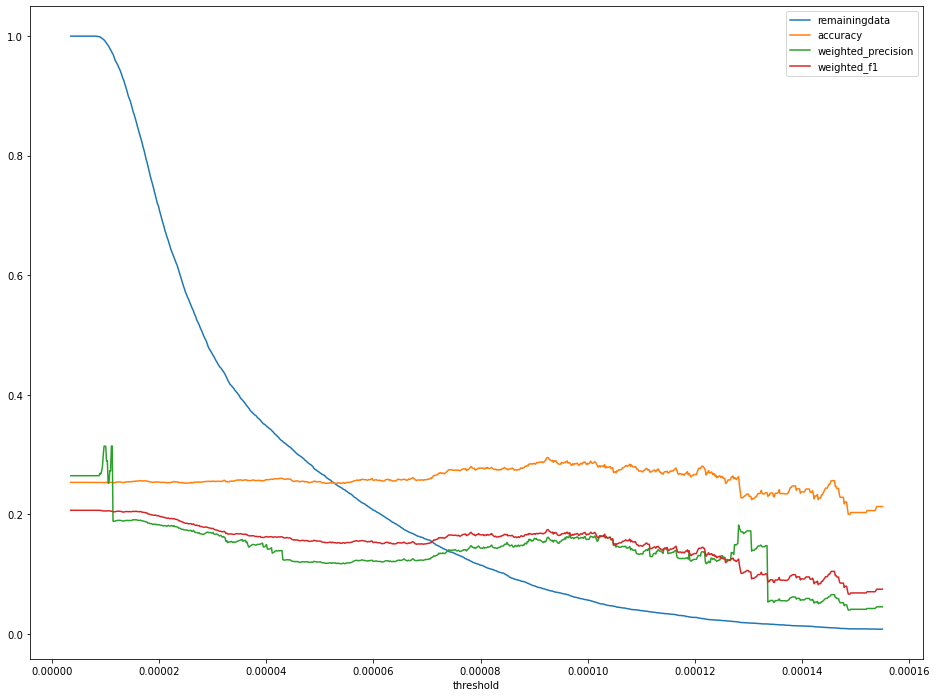

In [80]:
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','accuracy','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','accuracy','weighted_precision','weighted_f1'],figsize=(16,12))

In [81]:
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=1]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracy,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,remainingdata
35,0.206855,0.253655,0.26472,0.253655,7593.0,7593.0,7593.0,0.264717,0.253653,0.206847,7593.0,0.000009,0.999079


In [82]:
#Loading the results file (as the embedding vectors change in each run of distilbertmulti)

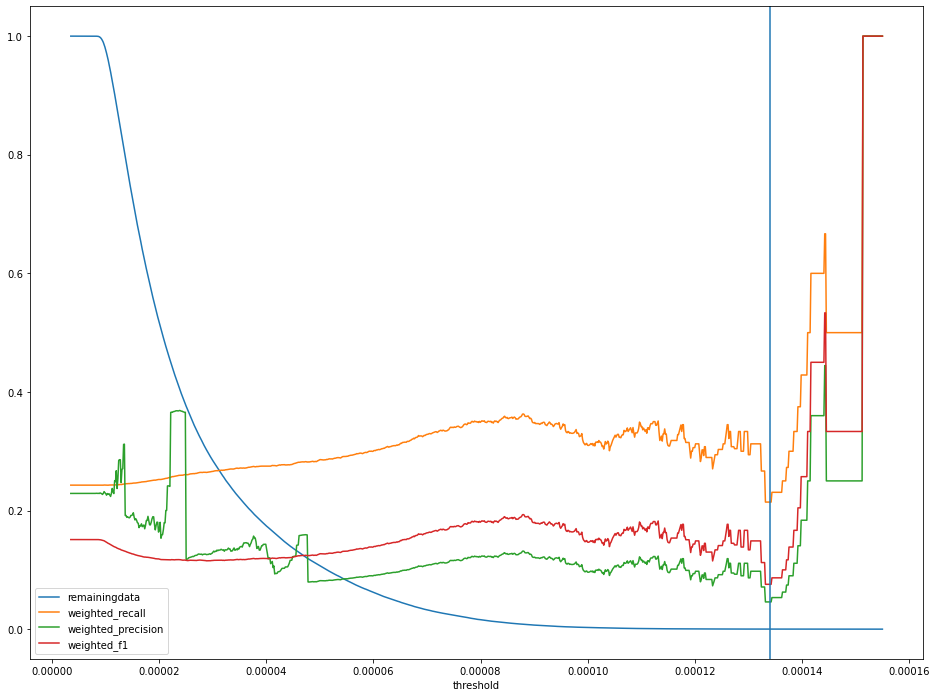

In [83]:
results=pd.read_json('results_ag_news_train_distilbertmulti.json')
results['remainingdata']=results['length']/(results['length'].max())  
results.loc[:,['remainingdata','weighted_recall','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','weighted_recall','weighted_precision','weighted_f1'],figsize=(16,12))
plt.axvline(0.000134)

In [84]:
results[results['weighted_f1']==results[results['threshold']<=0.000134]['weighted_f1'].max()]

,weighted_f1,weighted_recall,weighted_precision,accuracyf1,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,lengthsmall,remainingdata
557,0.193262,0.362903,0.131699,0.362903,992,992,992,0.090726,0.25,0.133136,992,0.000088,0.008267,0.008267


,weighted_f1,weighted_recall,weighted_precision,accuracyf1,supportaccur,supportmacro,supportweighted,macro_precision,macro_recall,macro_f1,length,threshold,lengthsmall,remainingdata
30,0.230345,0.248495,0.247253,0.248495,5980,5980,5980,0.246582,0.247924,0.230112,5980,0.000008,0.786842,0.786842


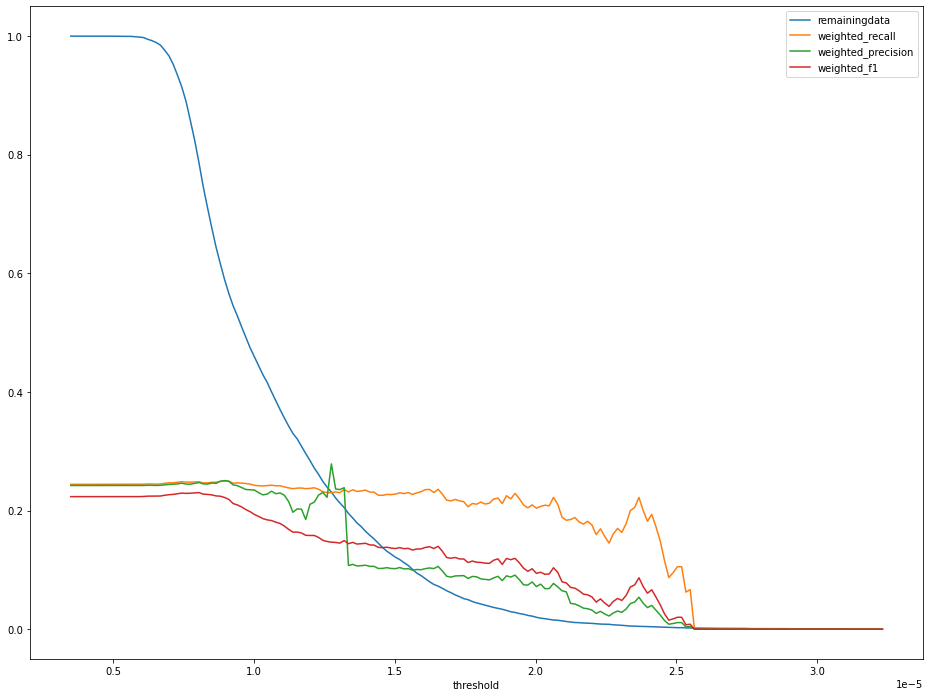

In [85]:
resultstestds=pd.read_json('results_ag_news_test_distilbertmulti.json')
resultstestds['remainingdata']=resultstestds['length']/(resultstestds['length'].max())  
resultstestds.loc[:,['remainingdata','weighted_recall','weighted_precision','weighted_f1','threshold']].plot(x='threshold',y=['remainingdata','weighted_recall','weighted_precision','weighted_f1'],figsize=(16,12))
resultstestds[resultstestds['weighted_f1']==resultstestds[resultstestds['threshold']<=1]['weighted_f1'].max()]

In [86]:
# The code structure of the embedding function is inspired from:
# Pietro, Mauro Di. 2020. Bert for text classification with no model training